# Logistic Regression II

Making decisions and assessing performance.

[Acknowledgments Page](https://ds100.org/su23/acks/)

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.linear_model as lm

We'll continue with the `games` dataset from last lecture.

In [43]:
basketball = pd.read_csv("nba.csv")

one_team = basketball.groupby("GAME_ID").first()
opponent = basketball.groupby("GAME_ID").last()
games = one_team.merge(opponent, left_index = True, right_index = True, suffixes = ["", "_OPP"])
games['GOAL_DIFF'] = games["FG_PCT"] - games["FG_PCT_OPP"]
games['WON'] = games['WL'].replace('L', 0).replace('W', 1)

games = games[['TEAM_NAME', 'MATCHUP', 'WON', 'GOAL_DIFF', 'AST']].sort_values("GOAL_DIFF")
games

,TEAM_NAME,MATCHUP,WON,GOAL_DIFF,AST
GAME_ID,,,,,
21701216,Dallas Mavericks,DAL vs. PHX,0,-0.251,20
21700846,Phoenix Suns,PHX @ GSW,0,-0.237,13
21700071,San Antonio Spurs,SAS @ ORL,0,-0.234,19
21700221,New York Knicks,NYK @ TOR,0,-0.234,17
21700306,Miami Heat,MIA @ NYK,0,-0.222,21
...,...,...,...,...,...
21700514,Golden State Warriors,GSW vs. UTA,1,0.191,37
21700280,Toronto Raptors,TOR @ ATL,1,0.201,31
21700276,Golden State Warriors,GSW vs. CHI,1,0.228,36


As before, we will use the `"GOAL_DIFF"` feature to classify whether a team won (1) or lost (0) their game.

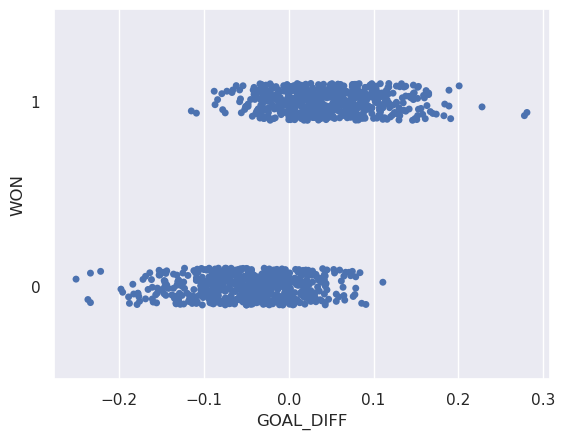

In [44]:
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", order=[1, 0], color=sns.color_palette()[0]);

## Decision Boundaries

The `LogisticRegression` class of `sklearn.linear_model` behaves very similarly to the `LinearRegression` class. As before, we:

1. Initialize a model object
2. Fit it to our data

Now, rather than predict a numeric output, we predict the *probability* of a datapoint belonging to Class 1. We do this using the `.predict_proba` method.

In [45]:
X = games[["GOAL_DIFF"]]
Y = games["WON"]

model = lm.LogisticRegression()
model.fit(X, Y)

# Preview the first 10 rows
model.predict_proba(X)[:10]

array([[0.9521269 , 0.0478731 ],
       [0.94399293, 0.05600707],
       [0.94208808, 0.05791192],
       [0.94208808, 0.05791192],
       [0.93384531, 0.06615469],
       [0.9140087 , 0.0859913 ],
       [0.91213212, 0.08786788],
       [0.90526966, 0.09473034],
       [0.904251  , 0.095749  ],
       [0.90007786, 0.09992214]])

By default, `.predict_proba` returns a 2D array: one column contains the predicted probability that the datapoint belongs to Class 0, and the other contains the predicted probability that it belongs to Class 1 (notice that all rows sum to a total probability of 1). To check which is which, we can use the `.classes_` attribute.

In [46]:
model.classes_

array([0, 1])

This tells us that the first column contains the probabilities of belonging to Class 0 (losing the game), and the second column contains the probabilities of belonging to Class 1 (winning). Let's grab just the probabilities of Class 1.

We then apply a decision rule: predict Class 1 if the predicted probability of belonging to Class 1 is 0.5 or higher. Otherwise, predict Class 0.

In [47]:
# Grab P(Y=1|x) from the output
p = model.predict_proba(X)[:, 1]

# Apply decision rule: predict Class 1 if P(Y=1|x) >= 0.5
(p >= 0.5).astype(int)

array([0, 0, 0, ..., 1, 1, 1])

The `.predict` method of `LogisticRegression` will automatically apply a 0.5 threshold to classify data.

In [48]:
# .predict will automatically apply a 0.5 threshold for a logistic regression model
classes = model.predict(X)

classes

array([0, 0, 0, ..., 1, 1, 1])

Let's visualize our predictions.

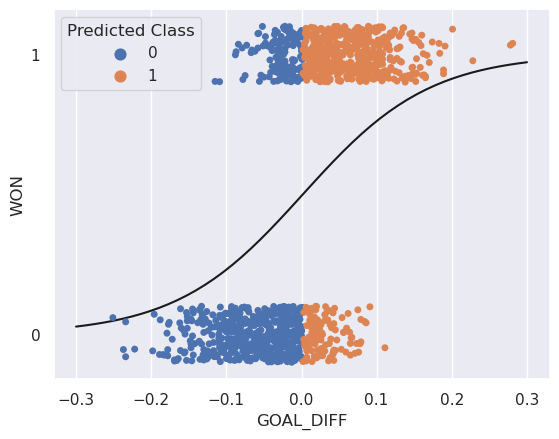

In [49]:
games["Predicted Class"] = classes

def sigmoid(z):
    return 1/(1+np.exp(-z))

x = np.linspace(-0.3, 0.3)
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", hue="Predicted Class", orient="h")
plt.plot(x, sigmoid(model.intercept_ + model.coef_[0]*x), "k", label="P(Y=1|x)")
plt.gca().invert_yaxis();

Any time the predicted probability $p$ is less than 0.5, the model predicts Class 0. Otherwise, it predicts Class 1.

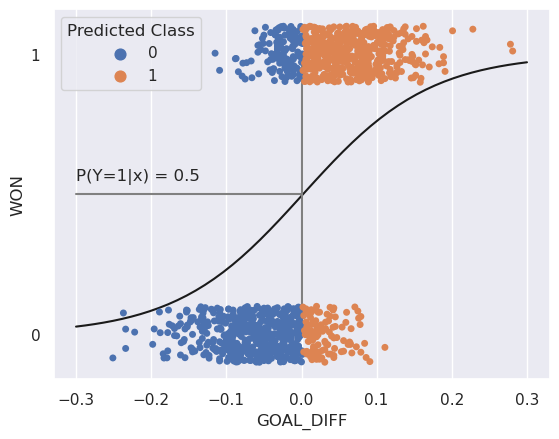

In [50]:
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", hue="Predicted Class", orient="h")
plt.plot(x, sigmoid(model.intercept_ + model.coef_[0]*x), "k", label="P(Y=1|x)")
plt.plot([-0.3, 0], [0.5, 0.5], "gray")
plt.plot([0, 0], [1, 0], "gray")
plt.gca().invert_yaxis()
plt.annotate("P(Y=1|x) = 0.5", (-0.3, 0.55));

A decision boundary describes the line the splits the data into classes based on its features. 

For a model with one feature, the decision boundary is a *point* that separates the two classes. We visualize this using a rugplot to plot all datapoints in terms of *just* the feature – we cannot define a decision boundary in terms of the predictions, so we remove that axis from our plot.

Notice that all datapoints to the right of our decision boundary are classified as Class 1, while all datapoints to the left care classified as Class 0.

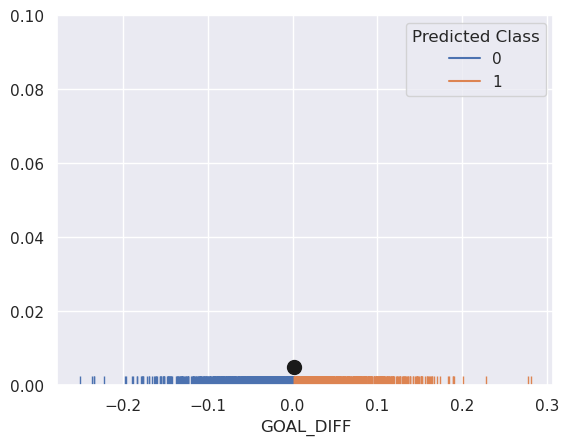

In [51]:
# Determine the decision boundary
theta0 = model.intercept_
theta1 = model.coef_[0]
T = 0.5
db = (1/theta1)*(-np.log(1/T - 1) - theta0)

# Visualize the classified data
sns.rugplot(data=games, x="GOAL_DIFF", hue="Predicted Class")
plt.scatter(x=[db], y=[0.005], c="k", s=100)
plt.ylim(0, 0.1);

We can repeat this process with a model with two features: `"AST"` and `"GOAL_DIFF"`. Now, we express a decision boundary in terms of both of these two features.

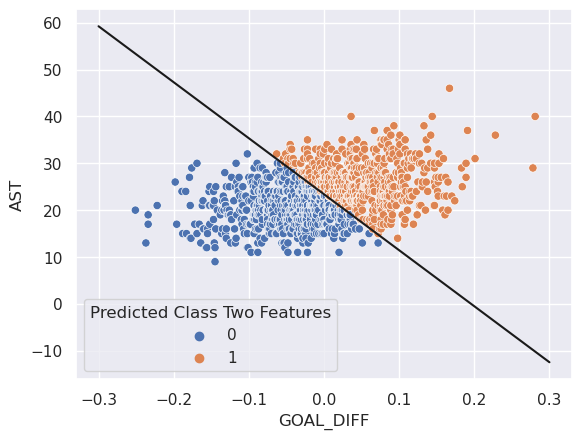

In [52]:
X_two_feature = games[["GOAL_DIFF", "AST"]]
Y = games["WON"]

two_feature_model = lm.LogisticRegression()
two_feature_model.fit(X_two_feature, Y)


# This function plots the decision boundary such that AST is a function of GOAL_DIFF
theta0 = two_feature_model.intercept_
theta1, theta2 = two_feature_model.coef_[0]
T = 0.5
db = lambda goal_diff: (1/theta2)*(-np.log(1/T - 1) - theta1*goal_diff - theta0)

games["Predicted Class Two Features"] = two_feature_model.predict(X_two_feature)
sns.scatterplot(data=games, x="GOAL_DIFF", y="AST", hue="Predicted Class Two Features")
plt.plot(x, db(x), "k");

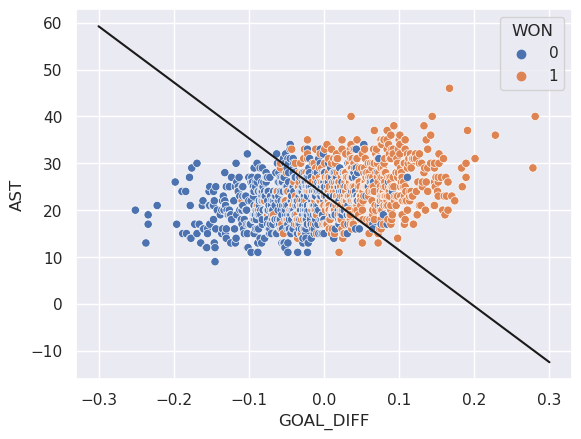

In [53]:
# This time, visualize the true classes
sns.scatterplot(data=games, x="GOAL_DIFF", y="AST", hue="WON")
plt.plot(x, db(x), "k");

## Linear Separability

A **linearly separable** dataset is one that can be perfectly separated into two classes by a hyperplane among the input features. A hyperplane is a decision boundary extended to arbitrarily many dimensions (for example, a model with three features would have a 3D surface as its decision boundary).

This dataset is linearly separable:

In [ ]:
iris = sns.load_dataset('iris')

plt.figure(figsize=(6, 4))

# Separable
sns.scatterplot(data = iris[iris['species'] != 'virginica'],
               x = 'petal_length',
               y = 'petal_width',
               hue = 'species', s=100);
plt.gca().legend_.set_title(None)

And this dataset is not.

In [ ]:
# Not separable
plt.figure(figsize=(6, 4))
sns.scatterplot(data = iris[iris['species'] != 'setosa'],
               x = 'petal_length',
               y = 'petal_width',
               palette=sns.color_palette()[1:3],
               hue = 'species', s=100);
plt.gca().legend_.set_title(None)

When our data is linearly separable, we run the risk of **diverging weights** as the model attempts to reduce cross-entropy loss to 0.

To see why, consider the following artificially-generated "toy" dataset.

In [ ]:
toy_df = pd.DataFrame({"x": [-1, 1], "y": [0, 1]})
sns.scatterplot(data=toy_df, x='x', y='y', hue="y", s=100, legend=None);

Let's look at the mean cross-entropy loss surface for this toy dataset, and a single feature model $\hat{y} = \sigma(\theta x)$.

For this situation, our logistic regression model takes the form:

$$ \Large \hat{P}_{\theta}(Y = 1 | x) = \sigma(\theta_1 x) = \frac{1}{1 + e^{-\theta_1 x}} $$

With mean cross-entropy loss:

\begin{align}
\hat{\theta} &= \underset{\theta}{\operatorname{argmin}}  - \frac{1}{n} \sum_{i=1}^n \left( y_i \log (\sigma(\theta_1 x_i) + (1 - y_i) \log (1 - \sigma(\theta_1 x_i)) \right) \\
&= \underset{\theta}{\operatorname{argmin}} -\frac{1}{2} \left[ \log (\sigma( -  \theta_1 )) + \log(1 - \sigma(\theta_1))\right]
\end{align}

In [ ]:
def toy_model(theta1, x):
    return 1/(1 + np.exp(-theta1 * x))

def mean_cross_entropy_loss_toy(theta1):
    # Here we use 1 - sigma(z) = sigma(-z) to improve numerical stability
    return - np.sum(toy_df['y'] * np.log(toy_model(theta1, toy_df['x'])) + \
                    (1-toy_df['y']) * np.log(toy_model(theta1, -toy_df['x'])))

In [ ]:
thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [mean_cross_entropy_loss_toy(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross Enropy Loss($\theta$)')
plt.xlabel(r'$\theta$');
plt.title("Mean Cross Entropy Loss Surface");

It's hard to see, but the "flat" region to the right actually tilts downwards! Take a look at the last 10 losses we computed – they all decrease slightly one after the other.

In [ ]:
[mean_cross_entropy_loss_toy(theta) for theta in thetas][-10:]

If left unchecked, the logistic regression model will attempt to use *infinite* values as the "optimal" model parameters. We describe this phenomenon as the model weights "**diverging**". Gradient descent will never converge, and our model becomes impractical.

We can use **regularization** to restrict how large the model parameters can be.

In [ ]:
def mce_regularized_loss_single_arg_toy(theta, reg):
    return mce_loss_single_arg_toy(theta) + reg * theta**2 

def regularized_loss_toy(theta1, reg):
    return mean_cross_entropy_loss_toy(theta1) + reg * theta1**2

thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [regularized_loss_toy(theta, 0.1) for theta in thetas], color = 'green')
plt.ylabel(r'MCE($\theta$) + 0.1 $\theta^2$')
plt.xlabel(r'$\theta$');
plt.title(r"Mean Loss + L2 Regularization ($\lambda$ = 0.1)");

Much better!

By default, `sklearn`'s `LogisticRegression` applies regularization for us. Phew.

## Performance Metrics

Let's return to our `games` data. We'll compute the **accuracy** of our `model` on this data.



In [ ]:
def accuracy(X, Y):
    return np.mean(model.predict(X) == Y)

accuracy(X, Y)

As per usual, `scikit-learn` can do this for us. The `.score` method of a `LogisticRegression` classifier gives us the accuracy of it.

In [ ]:
model.score(X, Y)

### Confusion matrix

Our good old friend `scikit-learn` has an in-built confusion matrix method (of course it does).

In [ ]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(Y, model.predict(X))
cm

In [ ]:
cm = confusion_matrix(Y, model.predict(X))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Precision and Recall

We can also compute the number of TP, TN, FP, and TN for our classifier, and hence its precision and recall.

In [ ]:
Y_hat = model.predict(X)
tp = np.sum((Y_hat == 1) & (Y == 1))
tn = np.sum((Y_hat == 0) & (Y == 0))

fp = np.sum((Y_hat == 1) & (Y == 0))
fn = np.sum((Y_hat == 0) & (Y == 1))

tp, tn, fp, fn

These numbers match what we see in the confusion matrix above.

In [ ]:
precision = tp / (tp + fp)
precision

In [ ]:
recall = tp / (tp + fn)
recall

### True and False Positive Rates

The TP, TN, FP, and TN we just calculated also allow us to compute the true and false positive rates. Recall (haha) that the true positive rate is the same as recall.

In [ ]:
fpr = fp/(fp + tn)
fpr

In [ ]:
tpr = tp/(tp + fn)
tpr

It's important to remember that these values are all for the threshold of $T = 0.5$, which is `scikit-learn`'s default.

## Adjusting the Classification Threshold

Let's remind ourselves of our original `games` data.

In [ ]:
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", order=[1, 0], color=sns.color_palette()[0]);

Before, we used a threshold of 0.5 in our decision rule: if the predicted probability was greater than 0.5 we predicted Class 1, otherwise, we predicted Class 0.

What happens if we change the threshold? Below, we apply a threshold of $T=0.25$.

In [ ]:
model = lm.LogisticRegression()
model.fit(X, Y)

p = model.predict_proba(X)[:, 1]
# Predict Class 1 if the predicted probability >= 0.25
y_hat = (p >= 0.25).astype(int)

In [ ]:
theta0 = model.intercept_
theta1 = model.coef_[0]
decision_boundary_T25 = (1/theta1)*(-np.log(1/0.25 - 1) - theta0)

x = np.linspace(-0.3, 0.3)
sns.stripplot(x=games["GOAL_DIFF"], y=games["WON"], hue=y_hat, orient="h")
plt.plot(x, sigmoid(model.intercept_ + model.coef_[0]*x), "k", label="P(Y=1|x)")
plt.gca().invert_yaxis()

plt.annotate(f"Decision Boundary:\nx = {np.round(decision_boundary_T25[0], 3)}", (-0.3, 0.5));

When we lower the threshold, we require a lower predicted probability before we predict Class 1. We can think of this as us telling our model that it needs to be less "confident" about a datapoint being Class 1 before making a positive prediction. The total number of datapoints predicted to be Class 1 increases.

The converse happens if we raise the threshold. Consider setting $T=0.75$. Now, we require a higher predicted probability before we predict Class 1. The total number of datapoints predicted to be Class 1 decreases.

In [ ]:
y_hat = (p > 0.75).astype(int)

decision_boundary_T75 = (1/theta1)*(-np.log(1/0.75 - 1) - theta0)

x = np.linspace(-0.3, 0.3)
sns.stripplot(x=games["GOAL_DIFF"], y=games["WON"], hue=y_hat, orient="h")
plt.plot(x, sigmoid(model.intercept_ + model.coef_[0]*x), "k", label="P(Y=1|x)")
plt.gca().invert_yaxis()

plt.annotate(f"Decision Boundary:\nx = {np.round(decision_boundary_T75[0], 3)}", (0.1, 0.5));


## Thresholds and Performance Metrics

How does changing the threshold impact our performance metrics?

Let's run an experiment: we'll test out several different possible thresholds. For each threshold $T$, we'll make a decision rule where we classify any point with a predicted probability equal to or greater than $T$ as being in Class 1. Otherwise, we'll predict Class 0. We'll then compute the overall accuracy of the classifier when using that threshold.

In [ ]:
# Define performance metrics dependent on the threshold value

def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def accuracy_threshold(X, Y, T):
    return np.mean(predict_threshold(model, X, T) == Y)

def precision_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y_hat == 1)
    
def recall_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def tpr_threshold(X, Y, T): # Same as recall
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)

In [ ]:
# Compute accuracies for different thresholds
thresholds = np.linspace(0, 1, 100)
accs = [accuracy_threshold(X, Y, t) for t in thresholds]


plt.plot(thresholds, accs)
plt.xlabel("Threshold")
plt.ylabel("Accuracy");

In [ ]:
# The threshold that maximizes accuracy
thresholds[np.argmax(accs)]

It turns out that setting $T=0.5$ does not always result in the best performance! Part of the model design process for classification includes **choosing an appropriate threshold value**.

### Precision-Recall Curves
In lecture, we noted that there is a tradeoff between precision and recall.

Precision $=\frac{TP}{TP+FP}$ increases as the number of false positives decreases, which occurs as the threshold is raised.

Recall $=\frac{TP}{TP+FN}$ increases as the number of false negatives decreases, which occurs as the threshold is lowered.

We want to keep both precision and recall high. To do so, we'll need to strategically choose a threshold value.

In [ ]:
precisions = [precision_threshold(X, Y, t) for t in thresholds]
recalls = [recall_threshold(X, Y, t) for t in thresholds]

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend();

A **precision-recall** curve tests out many possible thresholds. Each point on the curve represents the precision and recall of the classifier for a *particular choice of threshold*.

We choose a threshold value that keeps both precision and recall high (usually in the rightmost "corner" of the curve).

In [ ]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision");

### ROC Curves

We can repeat a similar experiment for the FPR and TPR. Remember that we want to keep FPR *low* and TPR *high*. 

In [ ]:
tprs = [tpr_threshold(X, Y, t) for t in thresholds]
fprs = [fpr_threshold(X, Y, t) for t in thresholds]

plt.plot(thresholds, tprs, label="True Positive Rate")
plt.plot(thresholds, fprs, label="False Positive Rate")
plt.xlabel("Threshold")
plt.ylabel("TPR/FPR")
plt.legend();

A **ROC curve** tests many possible decision rule thresholds. For each possible threshold, it plots the corresponding precision and recall of the classifier.

"ROC" stands for "Receiver Operating Characteristic". It comes from the field of signal processing.

In [ ]:
plt.plot(fprs, tprs)
plt.xlabel("FPR")
plt.ylabel("TPR");

 Ideally, a perfect classifier would have a FPR of 0 and TPR of 1. The area under the perfect classifier is 1. 
 
 We often use the area under the ROC curve (abbreviated "AUC") as an indicator of model performance. The closer the AUC is to 1, the better.

In [ ]:
plt.plot(fprs, tprs, label="Our classifier")
plt.plot([0, 0, 1], [0, 1, 1], label="Perfect Classifier")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();